In [1]:
import mlrun
from mlrun import feature_store as fs
from mlrun.feature_store import Entity 

In [2]:
from mlrun.datastore.targets import RedisNoSqlTarget, ParquetTarget
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [3]:
import nuclio
import pandas as pd
import kafka

In [4]:
import os
import requests

In [5]:
project_name = 'kafka-fs-test'

In [6]:
project = mlrun.get_or_create_project(project_name,'./',user_project=True)

> 2022-12-08 10:59:12,503 [info] loaded project kafka-fs-test from MLRun DB


#### Creates Kafka Topics and Consumers

In [7]:
topic_in = "input_topic_fs_1"
topic_out = "output_topic_fs_1"
topic_err = "error_topic__fs_1"
brokers = 'my-kafka.default-tenant.svc.cluster.local:9092'

In [8]:
kafka_admin_client = kafka.KafkaAdminClient(bootstrap_servers=brokers)

In [9]:
# kafka_admin_client.create_topics([kafka.admin.NewTopic(topic_in, 2, 1)])

In [10]:
# kafka_admin_client.create_topics([kafka.admin.NewTopic(topic_out, 1, 1)])

In [11]:
# kafka_admin_client.create_topics([kafka.admin.NewTopic(topic_err, 1, 1)])

In [12]:
kafka_consumer_in = kafka.KafkaConsumer(topic_in,bootstrap_servers=brokers,auto_offset_reset="earliest",max_poll_records=3)

In [13]:
kafka_consumer_out = kafka.KafkaConsumer(topic_out,bootstrap_servers=brokers,auto_offset_reset="earliest",)

In [14]:
kafka_consumer_err = kafka.KafkaConsumer(topic_err,bootstrap_servers=brokers,auto_offset_reset="earliest",)

#### Creating FS

In [15]:
redis_path='redis://redis-test-master.default-tenant.svc.cluster.local:6379'

In [16]:
source_path = './data/data_ingest.csv'

In [17]:
transactions_data = pd.read_csv(source_path)

In [18]:
transactions_data = transactions_data.sample(100)

In [19]:
#Sort value by time that the last time record will be the last row in the table
transactions_data = transactions_data.sort_values(['timestamp'])

In [20]:
# mlrun: start-code

In [21]:

def len_device(event):
    event['len_device']=len(event['device'])
    return event

def check_len_device(event):
    if event['len_device'] > 5:
        event['check_len_device'] = 'Bigger Then 5'
        return event 
    else:
        event['check_len_device'] = 'Smaller Or Equal to 5'
        return event

In [22]:
# mlrun: end-code

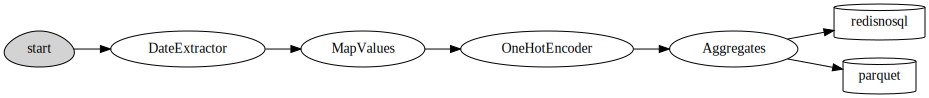

In [23]:
# Define and add value mapping
transaction_set = fs.FeatureSet("transactions", 
                                 entities=[fs.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping)).respond()


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
targets = [RedisNoSqlTarget(path=redis_path),ParquetTarget()]
transaction_set.set_targets(
    targets=targets,
    with_defaults=False,
)
# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

In [24]:
ingest_df=fs.ingest(transaction_set, transactions_data,overwrite=True,infer_options=fs.InferOptions.default())

In [25]:
ingest_df

,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_count_2h,amount_count_12h,amount_count_24h,amount_avg_2h,...,category_es_travel,category_es_home,category_es_food,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1100337763,12.66,12.66,12.66,12.66,12.66,12.66,1.0,1.0,1.0,12.66,...,0,0,0,12.66,0,2022-12-04 10:15:20.854540,M1823072687,f6634d6b950742e9a9147963cef4e0f0,10,6
C1079254393,46.12,46.12,46.12,46.12,46.12,46.12,1.0,1.0,1.0,46.12,...,0,0,0,46.12,0,2022-12-04 10:22:21.539479,M1823072687,699ea8cf6e6f4a6ca219a5f5b889d83b,10,6
C1158646143,25.71,25.71,25.71,25.71,25.71,25.71,1.0,1.0,1.0,25.71,...,0,0,0,25.71,0,2022-12-04 10:52:07.652431,M348934600,cabd43510ca247bfbff985f033df877a,10,6
C1048694975,13.82,13.82,13.82,13.82,13.82,13.82,1.0,1.0,1.0,13.82,...,0,0,0,13.82,0,2022-12-04 10:53:48.776311,M1823072687,aa1968dc0c7545b982257c4b5561c978,10,6
C1033736586,35.41,35.41,35.41,35.41,35.41,35.41,1.0,1.0,1.0,35.41,...,0,0,0,35.41,0,2022-12-04 11:30:47.862275,M1823072687,30b269ae55984e5584f1dd5f642ac1a3,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1100053869,38.21,38.21,38.21,38.21,38.21,38.21,1.0,1.0,1.0,38.21,...,0,0,0,38.21,0,2022-12-06 07:33:39.286958,M1823072687,827b5be6e48140909e243e8f5bdb74dc,7,1
C1040980271,11.23,11.23,13.97,11.23,11.23,11.23,1.0,1.0,2.0,11.23,...,0,0,0,11.23,0,2022-12-06 08:09:52.176676,M348934600,8b8e907b340c4a01a8f451a89c9d3c51,8,1
C1088464518,25.99,25.99,25.99,25.99,25.99,25.99,1.0,1.0,1.0,25.99,...,0,0,0,25.99,0,2022-12-06 08:35:19.178525,M1823072687,4162925ed6fa446db58f0a2e5e9ba076,8,1


In [26]:
#check that all rows from the dataframe ingested
ingest_df.shape[0]==transactions_data.shape[0]

True

#### Creating a deploy_ingestion_service function

In [27]:
steps = mlrun.code_to_function('steps',kind='serving',image='mlrun/mlrun')

In [28]:
from mlrun.datastore import KafkaSource
source = KafkaSource(brokers=brokers,topics=topic_in)

ingest_service = fs.deploy_ingestion_service(transaction_set,source=source,run_config=fs.RunConfig(steps))

> 2022-12-08 10:59:25,911 [info] Starting remote function deploy
2022-12-08 10:59:26  (info) Deploying function
2022-12-08 10:59:26  (info) Building
2022-12-08 10:59:26  (info) Staging files and preparing base images
2022-12-08 10:59:26  (info) Building processor image
2022-12-08 11:00:31  (info) Build complete
> 2022-12-08 11:00:37,804 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-kafka-fs-test-shapira-steps.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['kafka-fs-test-shapira-steps-kafka-fs-test-shapira.default-tenant.app.jmglmvqnganv.iguazio-cd1.com/']}


#### Test ingest Data with a simple requests

In [29]:
import datetime
import time
import random
df_json=pd.read_json('./json_files/json_49991.json',orient='index',typ='series')
ingest_dict = df_json.to_dict()
ingest_dict
res=steps.invoke('/',ingest_dict)
print(res)

> 2022-12-08 11:00:37,970 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-kafka-fs-test-shapira-steps.default-tenant.svc.cluster.local:8080/'}
{'id': '28a365c7-9cb7-4d9c-b83c-53670f2edfdb'}


#### Send requests to the Kafka trigger

In [30]:
producer  = kafka.KafkaProducer(bootstrap_servers=[brokers])

In [31]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./json_files/') if isfile(join('./json_files/', f))]

In [32]:
onlyfiles.remove('json_49991.json')

In [33]:
import datetime
s = datetime.datetime.now()
import json
for file in onlyfiles:
    df_json=pd.read_json(f'./json_files/{file}',typ='series')
    ingest_dict = df_json.to_dict()
    ms=json.dumps(ingest_dict).encode('utf-8')
    producer.send(topic=topic_in,value=ms)

In [34]:
counter = 0
for i in onlyfiles:
    record = next(kafka_consumer_in)
    counter += 1
    print(record)

ConsumerRecord(topic='input_topic_fs_1', partition=1, offset=0, timestamp=1670342070374, timestamp_type=0, key=None, value=b'{"step": 139, "age": "2", "gender": "F", "zipcodeOri": 28007, "zipMerchant": 28007, "category": "es_transportation", "amount": 8.75, "fraud": 0, "timestamp": "2022-12-04 11:20:32.459283", "source": "C1189752912", "target": "M348934600", "device": "0b2e1112e43f46269902b6fefdae9615"}', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=282, serialized_header_size=-1)
ConsumerRecord(topic='input_topic_fs_1', partition=1, offset=1, timestamp=1670342070380, timestamp_type=0, key=None, value=b'{"step": 114, "age": "2", "gender": "F", "zipcodeOri": 28007, "zipMerchant": 28007, "category": "es_transportation", "amount": 16.29, "fraud": 0, "timestamp": "2022-12-04 13:52:47.966915", "source": "C1189752912", "target": "M348934600", "device": "7f398b2024bf419f89833c93fe659c48"}', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=2

In [35]:
#Check if all the inputs got into kafka
counter == len(onlyfiles)

True

#### Creating feature vectore

In [36]:
features = [
    "transactions.*",
]

vector = fs.FeatureVector("transactions-vector",features=features,description="this is my vector")
resp = fs.get_offline_features(vector,with_indexes=True)
#Preview the dataset
resp.to_dataframe().tail(5)

,timestamp,amount_avg_2h,amount_avg_12h,amount_avg_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_count_2h,amount_count_12h,amount_count_24h,...,category_es_contents,category_es_travel,category_es_home,category_es_food,amount,fraud,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1100053869,2022-12-06 07:33:39.286958,38.21,38.21,38.210,38.21,38.21,38.21,1.0,1.0,1.0,...,0,0,0,0,38.21,0,M1823072687,827b5be6e48140909e243e8f5bdb74dc,7,1
C1040980271,2022-12-06 08:09:52.176676,11.23,11.23,6.985,11.23,11.23,13.97,1.0,1.0,2.0,...,0,0,0,0,11.23,0,M348934600,8b8e907b340c4a01a8f451a89c9d3c51,8,1
C1088464518,2022-12-06 08:35:19.178525,25.99,25.99,25.990,25.99,25.99,25.99,1.0,1.0,1.0,...,0,0,0,0,25.99,0,M1823072687,4162925ed6fa446db58f0a2e5e9ba076,8,1
C1093826151,2022-12-06 08:38:29.409677,61.93,61.93,61.930,61.93,61.93,61.93,1.0,1.0,1.0,...,0,0,0,0,61.93,0,M348934600,a9210d6a44614b219e39db4be8e07f12,8,1
C1123042802,2022-12-06 09:23:02.465231,54.49,54.49,54.490,54.49,54.49,54.49,1.0,1.0,1.0,...,0,0,0,0,54.49,0,M348934600,dc566c99ba7149e8b8d183b67b40f5ef,9,1


In [37]:
svc = fs.get_online_feature_service(vector.uri)
resp = svc.get([{"source": 'C1145304322'}])
resp

[{'amount_count_2h': 0.0,
  'amount_count_12h': 0.0,
  'amount_count_24h': 0.0,
  'amount_sum_2h': 0.0,
  'amount_sum_12h': 0.0,
  'amount_sum_24h': 0.0,
  'amount_max_2h': -inf,
  'amount_max_12h': -inf,
  'amount_max_24h': -inf,
  'es_transportation_count_14d': 136.0,
  'es_health_count_14d': 136.0,
  'es_otherservices_count_14d': 136.0,
  'es_food_count_14d': 136.0,
  'es_hotelservices_count_14d': 136.0,
  'es_barsandrestaurants_count_14d': 136.0,
  'es_tech_count_14d': 136.0,
  'es_sportsandtoys_count_14d': 136.0,
  'es_wellnessandbeauty_count_14d': 136.0,
  'es_hyper_count_14d': 136.0,
  'es_fashion_count_14d': 136.0,
  'es_home_count_14d': 136.0,
  'es_contents_count_14d': 136.0,
  'es_travel_count_14d': 136.0,
  'es_leisure_count_14d': 136.0,
  'amount_avg_2h': nan,
  'amount_avg_12h': nan,
  'amount_avg_24h': nan,
  'age_mapped': '3',
  'step': 42,
  'age': '3',
  'gender_M': 0,
  'gender_F': 1,
  'zipcodeOri': 28007,
  'zipMerchant': 28007,
  'category_es_leisure': 0,
  'categ